In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -rf rl_experiments/


In [2]:
!GIT_LFS_SKIP_SMUDGE=1 git clone https://github.com/isayevlab/rl_experiments.git


Cloning into 'rl_experiments'...
remote: Enumerating objects: 95, done.
remote: Total 95 (delta 0), reused 0 (delta 0), pack-reused 95 (from 1)
Receiving objects: 100% (95/95), 445.13 MiB | 15.93 MiB/s, done.
Resolving deltas: 100% (32/32), done.
Updating files: 100% (58/58), done.


In [3]:
!pip install rdkit-pypi torch torchvision pandas matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 70.2 MB/s eta 0:00:00


In [4]:
!pip install joblib


In [5]:
import torch
print(torch.cuda.is_available())  # Should return True if GPU is available


True


In [6]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


In [7]:
import torch
print(torch.cuda.is_available())  # Should return True if GPU is available

True


In [ ]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [8]:
import sys
sys.path.append('/content/rl_experiments/release')


In [9]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import sys
sys.path.append('../release')

In [10]:
import numpy as np
import pandas as pd
from tqdm import trange
import torch
use_cuda = torch.cuda.is_available()

In [11]:
import os
print(os.getcwd())


/content


In [11]:
from data import GeneratorData, PredictorData
from stackRNN import StackAugmentedRNN
from utils import get_fp
from reinforcement import Reinforcement

In [12]:
import joblib
from sklearn.ensemble import RandomForestClassifier as RFC
from predictor import VanillaQSAR

# Training the predictor

In [ ]:
from rdkit import RDLogger

# Disable RDKit warnings
RDLogger.DisableLog('rdApp.*')

np.random.seed(42)

pred_data = PredictorData('rl_experiments/data/egfr_with_pubchem.csv', get_features=get_fp)
model_instance = RFC
model_params = {'n_estimators': 250,
                'n_jobs': 10}
my_predictor = VanillaQSAR(model_instance=model_instance,
                           model_params=model_params,
                           ensemble_size=10)

In [ ]:
# Train the model and retrieve metrics
results, metrics_type = my_predictor.fit_model(pred_data, cv_split='random')



In [ ]:
# Print out the results and calculate the average F1 score
print(f"Metrics Type: {metrics_type}")
for i, metric in enumerate(results):
    print(f"Fold {i+1}: {metrics_type} = {metric:.4f}")

# Calculate and print the average F1 score
average_f1 = np.mean(results)
print(f"Average {metrics_type}: {average_f1:.4f}")


Metrics Type: F1 score
Fold 1: F1 score = 0.8571
Fold 2: F1 score = 0.8301
Fold 3: F1 score = 0.8549
Fold 4: F1 score = 0.8525
Fold 5: F1 score = 0.8350
Fold 6: F1 score = 0.8465
Fold 7: F1 score = 0.8343
Fold 8: F1 score = 0.8540
Fold 9: F1 score = 0.8505
Fold 10: F1 score = 0.8357
Average F1 score: 0.8451


In [ ]:
# uncomment to train predictor model...
my_predictor.fit_model(pred_data, cv_split='random')
my_predictor.save_model('/content/drive/MyDrive/egfr_rfc')

In [ ]:
# ...or use pretrained model
my_predictor.load_model('/content/drive/MyDrive/egfr_rfc')

# Pre-train the generative model

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
tokens = [' ', '<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r']
gen_data_path = 'rl_experiments/data/chembl_22_clean_1576904_sorted_std_final.smi'
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t',
                         cols_to_read=[0], keep_header=True, tokens=tokens)

In [ ]:
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.0002
optimizer = torch.optim.Adadelta

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                     output_size=gen_data.n_characters,
                                     layer_type=layer_type, n_layers=1, is_bidirectional=False,
                                     has_stack=True, stack_width=stack_width, stack_depth=stack_depth,
                                     use_cuda=use_cuda,
                                     lr=lr, optimizer_instance=optimizer)

In [ ]:
model_path = '/content/rl_experiments/checkpoints/generator/egfr_clf_rnn_mixed_primed'
batch_size = 16
n_iterations = 1500000

# uncomment to pretrain generator...
# losses = my_generator.fit(gen_data, batch_size, n_iterations)
# my_generator.save_model('/content/drive/MyDrive/model_path')
# with open('losses.txt','wt') as f:
#     for val in losses:
#         print(val, file=f)

In [ ]:
# Force the model to load on CPU first
state_dict = torch.load(model_path, map_location='cpu')

# Then, load the state dictionary into your generator model
my_generator.load_state_dict(state_dict)

# Finally, move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
my_generator.to(device)


NameError: name 'model_path' is not defined

In [ ]:
print(torch.cuda.is_available())  # Should return True if GPU is available
print(torch.cuda.device_count())  # Should return the number of GPUs available


Iteration 1000/50000, Loss: 12.9343
Iteration 2000/50000, Loss: 10.5309
Iteration 3000/50000, Loss: 5.9506
Iteration 4000/50000, Loss: 10.5028
Iteration 5000/50000, Loss: 11.8164
Iteration 6000/50000, Loss: 8.8280
Iteration 7000/50000, Loss: 10.0768
Iteration 8000/50000, Loss: 9.8125
Iteration 9000/50000, Loss: 7.7691
Iteration 10000/50000, Loss: 6.5106
Iteration 11000/50000, Loss: 5.8323
Iteration 12000/50000, Loss: 5.0690
Iteration 13000/50000, Loss: 6.1537
Iteration 14000/50000, Loss: 10.0901
Iteration 15000/50000, Loss: 6.6745
Iteration 16000/50000, Loss: 5.6312
Iteration 17000/50000, Loss: 8.0564
Iteration 18000/50000, Loss: 4.8651
Iteration 19000/50000, Loss: 9.1946
Iteration 20000/50000, Loss: 6.0853
Iteration 21000/50000, Loss: 5.6609
Iteration 22000/50000, Loss: 4.8585
Iteration 23000/50000, Loss: 7.4008
Iteration 24000/50000, Loss: 6.1333
Iteration 25000/50000, Loss: 8.4590
Iteration 26000/50000, Loss: 5.1284
Iteration 27000/50000, Loss: 6.7884
Iteration 28000/50000, Loss: 5.

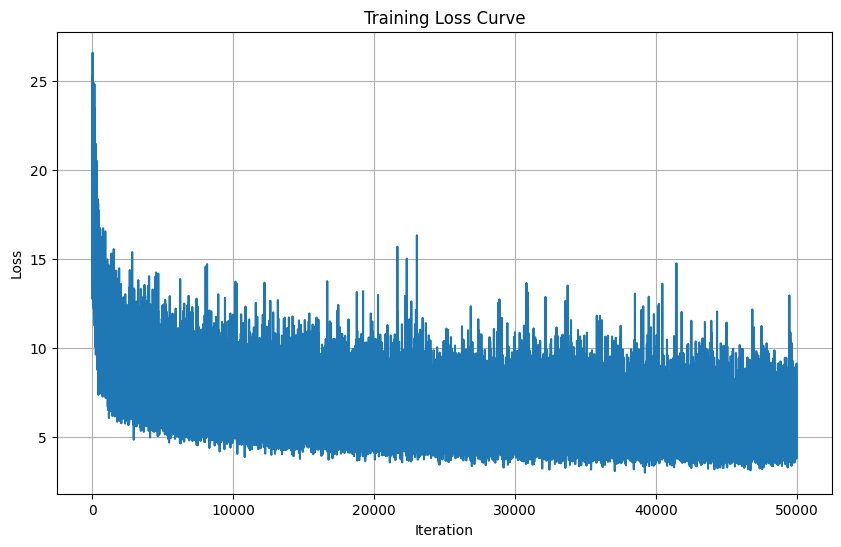

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

np.random.seed(42)
torch.manual_seed(42)

tokens = [' ', '<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r']
gen_data_path = 'rl_experiments/data/chembl_22_clean_1576904_sorted_std_final.smi'
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t',
                         cols_to_read=[0], keep_header=True, tokens=tokens)

hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.0002
optimizer = torch.optim.Adadelta

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters,
                                 layer_type=layer_type, n_layers=1, is_bidirectional=False,
                                 has_stack=True, stack_width=stack_width, stack_depth=stack_depth,
                                 use_cuda=use_cuda,
                                 lr=lr, optimizer_instance=optimizer)

model_path = '/content/rl_experiments/checkpoints/generator/egfr_clf_rnn_mixed_primed'
batch_size = 16
n_iterations = 28000

# Initialize an empty list to store losses
losses = []

# Training loop
for i in range(n_iterations):
    # Sample a batch from gen_data
    inputs, targets = gen_data.random_training_set(batch_size)

    # Train step with the inputs and targets
    loss = my_generator.train_step(inputs, targets)
    losses.append(loss)

    if (i + 1) % 1000 == 0:  # Print every 1000 iterations
        print(f"Iteration {i+1}/{n_iterations}, Loss: {loss:.4f}")

# Save the model
my_generator.save_model('/content/drive/MyDrive/model_path')

# Save losses to a file
with open('/content/drive/MyDrive/losses.txt', 'wt') as f:
    for val in losses:
        print(val, file=f)

# Plot the training loss curve
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


# **Without replay and dynamic threshold**


<ipython-input-13-320895010f54>:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(primed_path, map_location=lambda storage, loc: storage.cuda() if torc

1 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]
<ipython-input-13-320895010f54>:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  progress_df = pd.concat([progress_df, new_row], ignore_index=True)


2 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]


3 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  6.10it/s]


4 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


5 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


6 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.96it/s]


7 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.99it/s]


8 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.98it/s]


9 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.99it/s]


10 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.98it/s]


11 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.97it/s]


12 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.96it/s]


13 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.94it/s]


14 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.97it/s]


15 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.89it/s]


16 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


17 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.90it/s]


18 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.92it/s]


19 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.92it/s]


20 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.90it/s]


21 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.94it/s]


22 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.93it/s]


23 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.90it/s]


24 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


25 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.86it/s]


26 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


27 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.88it/s]


28 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


29 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


30 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.86it/s]


31 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


32 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.90it/s]


33 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


34 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


35 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


36 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


37 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


38 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


39 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


40 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


41 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


42 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


43 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


44 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


45 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


46 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


47 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


48 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


49 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


50 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


51 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


52 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


53 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


54 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


55 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


56 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


57 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


58 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


59 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


60 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:09<00:00,  5.34it/s]


61 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


62 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


63 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


64 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


65 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


66 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.70it/s]


67 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


68 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


69 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


70 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


71 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.71it/s]


72 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.69it/s]


73 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.69it/s]


74 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.68it/s]


75 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.71it/s]


76 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


77 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


78 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.69it/s]


79 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.67it/s]


80 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.68it/s]


81 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.68it/s]


82 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.70it/s]


83 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.66it/s]


84 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.70it/s]


85 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


86 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.66it/s]


87 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.70it/s]


88 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.69it/s]


89 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.69it/s]


90 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.67it/s]


91 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


92 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


93 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


94 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.71it/s]


95 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


96 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.70it/s]


97 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.65it/s]


98 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.69it/s]


99 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.71it/s]


100 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


101 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


102 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.68it/s]


103 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


104 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


105 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


106 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


107 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.63it/s]


108 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.70it/s]


109 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.70it/s]


110 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.71it/s]


111 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.71it/s]


112 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.67it/s]


113 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.71it/s]


114 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


115 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


116 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


117 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


118 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


119 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


120 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


121 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


122 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


123 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


124 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.70it/s]


125 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


126 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


127 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


128 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


129 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.70it/s]


130 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


131 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


132 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.71it/s]


133 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


134 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


135 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


136 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


137 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


138 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.71it/s]


139 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.66it/s]


140 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


141 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.68it/s]


142 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


143 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


144 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:10<00:00,  4.90it/s]


145 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


146 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


147 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


148 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


149 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


150 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.69it/s]


151 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


152 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


153 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


154 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


155 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


156 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


157 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


158 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


159 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.71it/s]


160 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


161 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


162 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.70it/s]


163 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.70it/s]


164 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


165 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


166 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


167 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


168 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


169 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


170 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


171 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


172 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


173 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


174 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


175 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


176 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


177 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.70it/s]


178 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


179 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


180 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


181 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


182 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


183 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


184 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


185 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


186 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.68it/s]


187 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


188 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


189 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


190 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


191 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


192 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


193 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


194 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


195 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


196 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


197 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


198 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


199 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


200 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.71it/s]


201 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


202 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


203 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


204 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


205 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


206 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


207 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


208 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


209 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.70it/s]


210 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


211 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


212 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


213 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


214 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.70it/s]


215 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


216 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


217 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


218 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.70it/s]


219 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


220 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


221 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


222 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


223 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


224 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


225 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


226 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


227 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


228 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


229 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


230 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


231 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


232 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


233 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


234 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


235 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


236 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


237 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


238 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


239 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


240 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


241 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.71it/s]


242 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


243 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


244 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


245 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


246 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:10<00:00,  4.56it/s]


247 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


248 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


249 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


250 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.69it/s]


251 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.71it/s]


252 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


253 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


254 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


255 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


256 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


257 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


258 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


259 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


260 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


261 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


262 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


263 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


264 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


265 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


266 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


267 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


268 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


269 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


270 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.70it/s]


271 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


272 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


273 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


274 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


275 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


276 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


277 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


278 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


279 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


280 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


281 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


282 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


283 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


284 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


285 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


286 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


287 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


288 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


289 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


290 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


Threshold increased to: 0.06
291 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


Threshold increased to: 0.06
292 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


293 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


294 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


295 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


296 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


297 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


298 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.67it/s]


Threshold increased to: 0.07
299 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


Threshold increased to: 0.07
300 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.71it/s]


Threshold increased to: 0.08
Training duration: 14478.157973766327 seconds


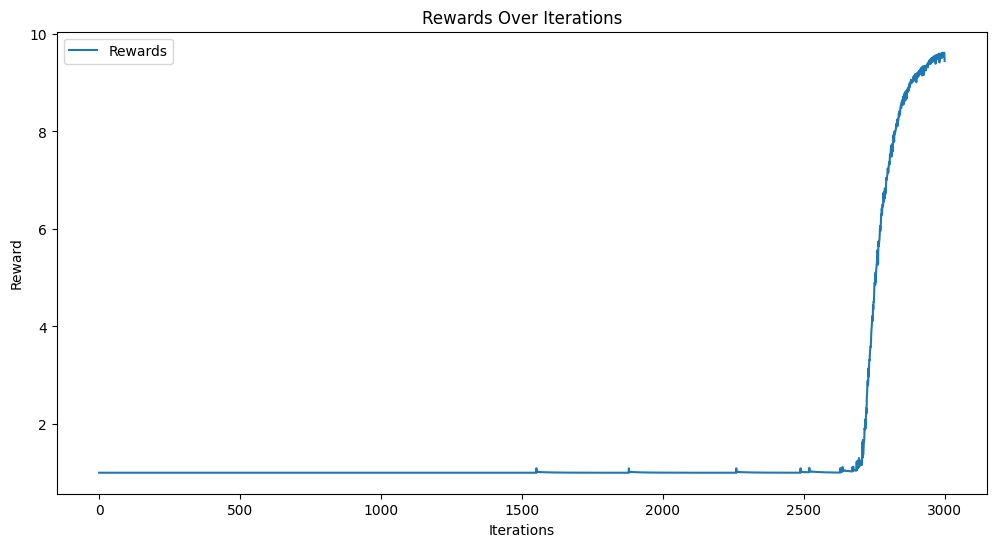

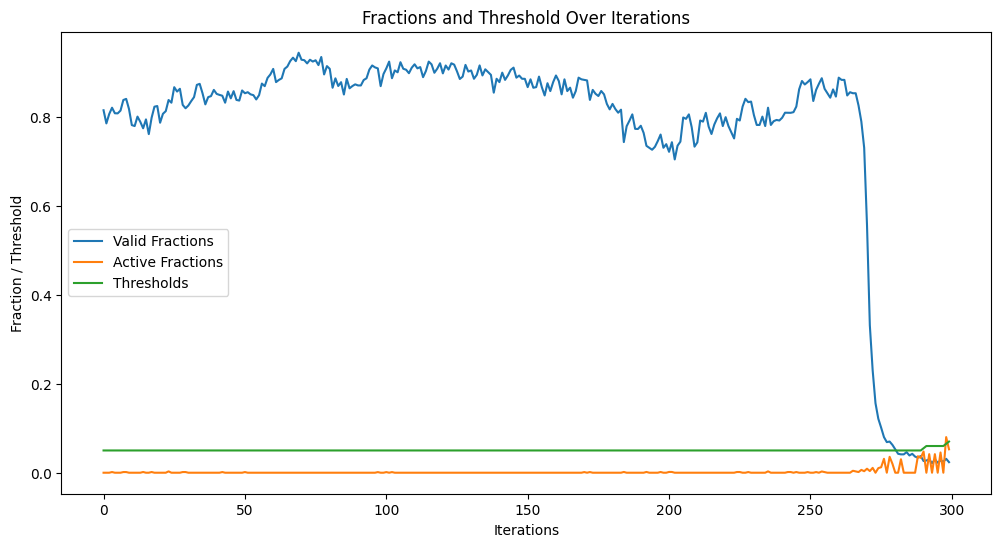

In [ ]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from rdkit import Chem, DataStructs
from sklearn.ensemble import RandomForestClassifier as RFC
from utils import canonical_smiles, get_fp
from stackRNN import StackAugmentedRNN
from data import GeneratorData
from predictor import VanillaQSAR
from reinforcement import Reinforcement
import time
import contextlib
from rdkit import RDLogger

# Suppress RDKit warnings and errors
RDLogger.DisableLog('rdApp.*')

# A function to suppress stderr (error messages)
@contextlib.contextmanager
def suppress_stderr():
    with open(os.devnull, 'w') as devnull:
        old_stderr = sys.stderr
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stderr = old_stderr

def estimate_and_update(generator, predictor, n_to_generate, threshold=None, batch_size=16,
                        plot_counts=False, plot=False, return_metrics=False, **kwargs):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        with suppress_stderr():
            generated += generator.evaluate(gen_data, predict_len=120, batch_size=batch_size)

    with suppress_stderr():
        sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    unique_smiles, counts = np.unique(sanitized, return_counts=True)
    unique_smiles, counts = list(unique_smiles)[1:], counts[1:]

    smiles, prediction, nan_smiles = predictor.predict(unique_smiles, get_features=get_fp)

    if plot_counts and plot:
        plt.hist(counts)
        plt.gca().set_yscale('log')
        plt.title('Distribution of counts of generated smiles')
        plt.xlabel('Counts observed')
        plt.show()

    valid_fraction = len(prediction) / len(generated)
    active_fraction = np.mean(prediction >= threshold)
    metrics = {'valid_fraction': valid_fraction, 'active_fraction': active_fraction}

    if return_metrics:
        return smiles, prediction, metrics
    else:
        return smiles, prediction

def plot_hist(prediction, n_to_generate, threshold=None, plot=True):
    print("Mean value of predictions:", prediction.mean())
    print("Proportion of valid SMILES:", len(prediction) / n_to_generate)
    if plot:
        plt.hist(prediction, bins=20, edgecolor='black')
        if threshold is not None:
            plt.axvline(x=threshold, color="red")
        plt.xlabel('Predicted pIC50')
        plt.title('Distribution of predicted pIC50 for generated molecules')
        plt.show()

def update_threshold(cur_threshold, prediction, proportion=0.15, step=0.005):
    if (prediction >= cur_threshold).mean() >= proportion:
        new_threshold = min(cur_threshold + step, 0.8)
        print(f"Threshold increased to: {new_threshold:.2f}")
        return new_threshold
    else:
        return cur_threshold

def simple_moving_average(prev_values, new_value, ma_window_size=10):
    ma_value = sum(prev_values[-(ma_window_size - 1):]) + new_value
    ma_value = ma_value / (len(prev_values[-(ma_window_size - 1):]) + 1.)
    return ma_value

def main(n_iterations=300, n_policy=10, n_policy_replay=15, batch_size=16, n_fine_tune=None,
         seed=None, replay_data_path='/content/rl_experiments/data/gen_actives.smi',
         primed_path='/content/rl_experiments/checkpoints/generator/checkpoint_batch_training',
         save_path=None):
"""
1. n_iterations (Outer Iterations)

    Role: n_iterations is the main loop that runs for a specified number of steps, often viewed as "epochs" in machine learning terminology.
    Purpose: Each iteration represents a full round of training where certain key operations happen (e.g., updating the threshold, generating molecules, and calculating rewards).
    Interpretation: Since n_iterations controls the number of times the entire training process is executed, it can indeed be thought of as analogous to epochs. Every time an outer iteration is completed, the model gains experience from that cycle and theoretically becomes more refined.

In this code:

    Each n_iterations step involves multiple molecule generation and evaluation operations.
    The threshold update and reward recording happen in each main iteration, so n_iterations essentially defines the broader progress of the training.

2. n_policy (Policy Gradient Steps within Each Outer Iteration)

    Role: n_policy represents the number of policy gradient updates performed within each outer iteration. For each main iteration (n_iterations), the code runs n_policy policy gradient steps, making small updates to the model.
    Purpose: These smaller steps allow the model to incrementally adjust its policy based on the reward received for each generated molecule.
    Interpretation: Rather than representing full training cycles (like epochs), n_policy can be seen as sub-steps within each epoch, where each step allows the model to adjust to the data at a finer level.
"""

    # Load progress if exists, or initialize
    progress_path = '/content/drive/MyDrive/training_progress.csv'
    if not os.path.exists(progress_path):
        progress_df = pd.DataFrame(columns=['iteration', 'reward', 'valid_fraction', 'active_fraction'])
    else:
        progress_df = pd.read_csv(progress_path)
        rewards = progress_df['reward'].tolist()
        valid_fractions = progress_df['valid_fraction'].tolist()
        active_fractions = progress_df['active_fraction'].tolist()

    if n_fine_tune is None:
        n_fine_tune = n_iterations

    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)

    gen_data_path = '/content/rl_experiments/data/chembl_22_clean_1576904_sorted_std_final.smi'
    tokens = [' ', '<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4',
              '7', '6', '9', '8', '=', 'a', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
              '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r']
    global gen_data
    gen_data = GeneratorData(gen_data_path, delimiter='\t',
                             cols_to_read=[0], keep_header=True, tokens=tokens)

    hidden_size = 1500
    stack_width = 1500
    stack_depth = 200
    layer_type = 'GRU'
    optimizer = torch.optim.SGD
    lr = 0.0002
    generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                  output_size=gen_data.n_characters, layer_type=layer_type,
                                  n_layers=1, is_bidirectional=False, has_stack=True,
                                  stack_width=stack_width, stack_depth=stack_depth,
                                  use_cuda=torch.cuda.is_available(), optimizer_instance=optimizer, lr=lr)
    weights = torch.load(primed_path, map_location=lambda storage, loc: storage.cuda() if torch.cuda.is_available() else storage.cpu())
    generator.load_state_dict(weights)

    model_instance = RFC
    model_params = {'n_estimators': 250, 'n_jobs': 10}
    predictor = VanillaQSAR(model_instance=model_instance,
                            model_params=model_params,
                            model_type='classifier')
    predictor.load_model('/content/drive/MyDrive/egfr_rfc')

    def get_reward(smiles, predictor, threshold, invalid_reward=1.0, get_features=get_fp):
        mol, prop, nan_smiles = predictor.predict([smiles], get_features=get_features)
        if len(nan_smiles) == 1:
            return invalid_reward
        if prop[0] >= threshold:
            return 10.0
        else:
            return invalid_reward

    RL_model = Reinforcement(generator, predictor, get_reward)

    rl_losses = []
    rewards = []
    valid_fractions = []
    active_fractions = []
    thresholds = []
    n_to_generate = 50
    threshold = 0.05
    start = time.time()

    for i in range(n_iterations):
        print(f"{i + 1} Training on replay instances...")
        thresholds.append(threshold)

        for j in trange(n_policy, desc=f" {i + 1} Policy gradient..."):
            cur_reward, cur_loss = RL_model.policy_gradient(gen_data, threshold=threshold)
            rewards.append(simple_moving_average(rewards, cur_reward))
            rl_losses.append(simple_moving_average(rl_losses, cur_loss))

        smiles_cur, prediction_cur, metrics = estimate_and_update(RL_model.generator,
                                                                  RL_model.predictor,
                                                                  n_to_generate,
                                                                  batch_size=batch_size,
                                                                  threshold=0.75,
                                                                  plot_counts=False,
                                                                  return_metrics=True)
        valid_fractions.append(metrics['valid_fraction'])
        active_fractions.append(metrics['active_fraction'])

        new_row = pd.DataFrame([{
            'iteration': i + 1,
            'reward': rewards[-1],
            'valid_fraction': valid_fractions[-1],
            'active_fraction': active_fractions[-1]
        }])
        progress_df = pd.concat([progress_df, new_row], ignore_index=True)

        progress_df.to_csv(progress_path, index=False)

        threshold = update_threshold(threshold, prediction_cur)

    duration = time.time() - start
    print(f"Training duration: {duration} seconds")

    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label='Rewards')
    plt.title('Rewards Over Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(valid_fractions, label='Valid Fractions')
    plt.plot(active_fractions, label='Active Fractions')
    plt.plot(thresholds, label='Thresholds')
    plt.title('Fractions and Threshold Over Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Fraction / Threshold')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    main(n_iterations=300)



Mounted at /content/drive


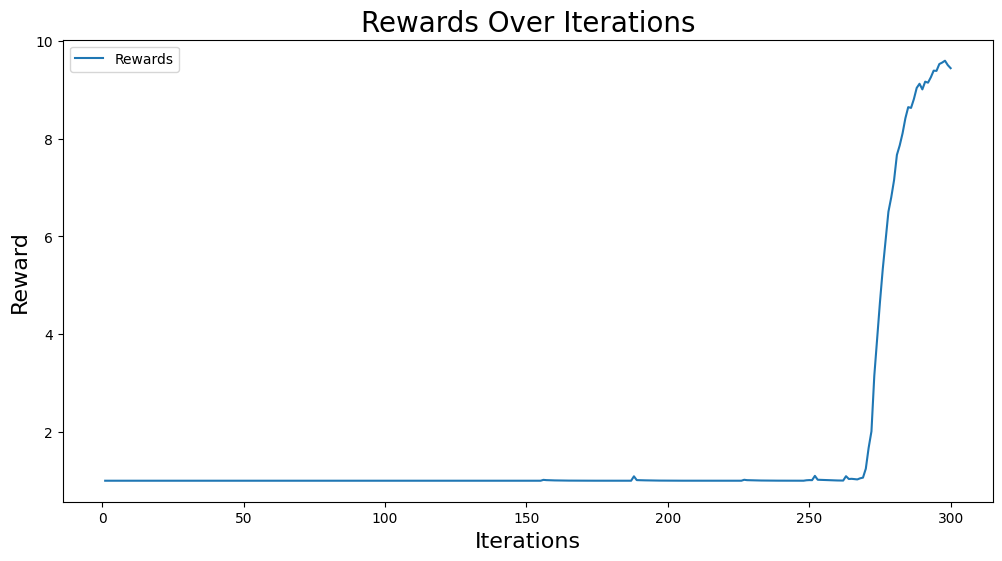

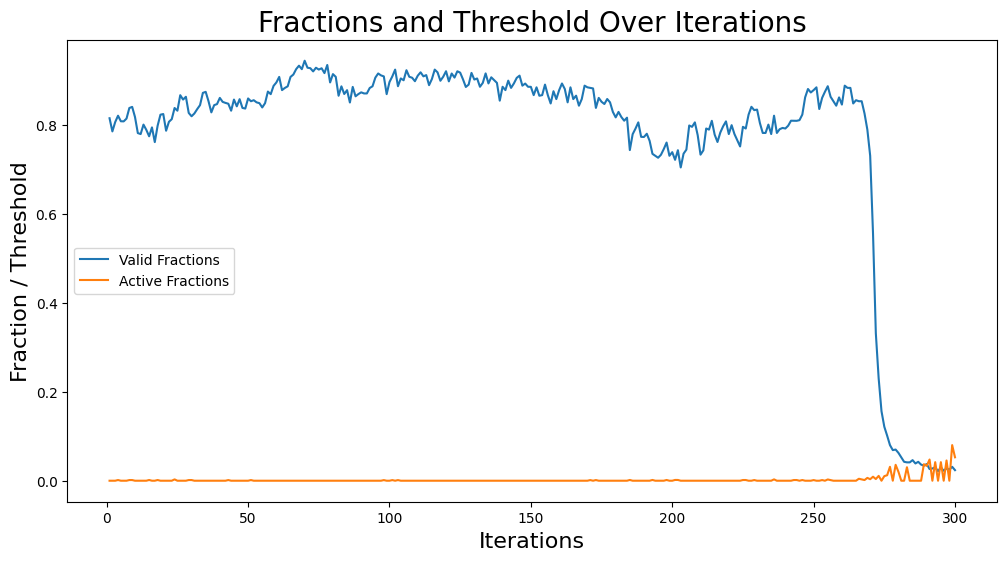

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')


# Define path to the CSV file
progress_path = '/content/drive/MyDrive/training_progress.csv'

# Check if the CSV file exists and load it
if os.path.exists(progress_path):
    progress_df = pd.read_csv(progress_path)

    # Extract data from DataFrame
    iterations = progress_df['iteration'].tolist()
    rewards = progress_df['reward'].tolist()
    valid_fractions = progress_df['valid_fraction'].tolist()
    active_fractions = progress_df['active_fraction'].tolist()

    # Plot Rewards over Iterations
    plt.figure(figsize=(12, 6))
    plt.plot(iterations, rewards, label='Rewards')
    plt.title('Rewards Over Iterations', fontsize=20)
    plt.xlabel('Iterations', fontsize=16)
    plt.ylabel('Reward', fontsize=16)
    plt.legend()
    plt.show()

    # Plot Valid and Active Fractions along with Thresholds over Iterations
    plt.figure(figsize=(12, 6))
    plt.plot(iterations, valid_fractions, label='Valid Fractions')
    plt.plot(iterations, active_fractions, label='Active Fractions')

    # Assuming you have threshold data in your CSV
    if 'threshold' in progress_df.columns:
        thresholds = progress_df['threshold'].tolist()
        plt.plot(iterations, thresholds, label='Thresholds')

    plt.title('Fractions and Threshold Over Iterations', fontsize=20)
    plt.xlabel('Iterations', fontsize=16)
    plt.ylabel('Fraction / Threshold', fontsize=16)
    plt.legend()
    plt.show()

else:
    print("The specified progress file does not exist.")


# **With replay and dynamic threshold**

<ipython-input-13-75ca225501ea>:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(primed_path, map_location=lambda storage, loc: storage.cuda() if torc

1 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.59it/s]
<ipython-input-13-75ca225501ea>:194: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  progress_df = pd.concat([progress_df, new_row], ignore_index=True)


2 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.97it/s]


3 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.96it/s]


4 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.91it/s]


5 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.91it/s]


6 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.93it/s]


7 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.95it/s]


8 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.88it/s]


9 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.92it/s]


10 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.93it/s]


11 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.90it/s]


12 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.89it/s]


13 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.91it/s]


14 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.89it/s]


15 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


16 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


17 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


18 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


19 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.88it/s]


20 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.88it/s]


21 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.92it/s]


22 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.88it/s]


23 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


24 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


25 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


26 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


27 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


Threshold increased to: 0.06
28 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


29 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.90it/s]


30 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.91it/s]


31 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


32 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


Threshold increased to: 0.06
33 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.07
34 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:09<00:00,  5.38it/s]


Threshold increased to: 0.07
35 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


Threshold increased to: 0.08
36 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.86it/s]


Threshold increased to: 0.08
37 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.86it/s]


Threshold increased to: 0.09
38 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.88it/s]


39 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


40 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.89it/s]


41 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.91it/s]


Threshold increased to: 0.09
42 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


Threshold increased to: 0.10
43 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.92it/s]


44 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.93it/s]


Threshold increased to: 0.10
45 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.91it/s]


Threshold increased to: 0.11
46 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.92it/s]


Threshold increased to: 0.11
47 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.91it/s]


Threshold increased to: 0.12
48 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


Threshold increased to: 0.12
49 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.91it/s]


Threshold increased to: 0.13
50 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.89it/s]


Threshold increased to: 0.13
51 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


Threshold increased to: 0.14
52 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.89it/s]


Threshold increased to: 0.14
53 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.89it/s]


Threshold increased to: 0.15
54 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.90it/s]


Threshold increased to: 0.15
55 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.92it/s]


Threshold increased to: 0.16
56 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


57 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.90it/s]


Threshold increased to: 0.16
58 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.86it/s]


Threshold increased to: 0.17
59 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


Threshold increased to: 0.17
60 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


Threshold increased to: 0.18
61 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


Threshold increased to: 0.18
62 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


Threshold increased to: 0.19
63 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


Threshold increased to: 0.19
64 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


Threshold increased to: 0.20
65 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


Threshold increased to: 0.20
66 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Threshold increased to: 0.21
67 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


68 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


69 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


70 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


71 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


72 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


73 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.21
74 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


75 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


76 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


77 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


Threshold increased to: 0.22
78 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


Threshold increased to: 0.22
79 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


Threshold increased to: 0.23
80 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.23
81 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.89it/s]


Threshold increased to: 0.24
82 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.24
83 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


Threshold increased to: 0.25
84 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.86it/s]


Threshold increased to: 0.25
85 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.26
86 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


Threshold increased to: 0.26
87 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.27
88 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.27
89 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


Threshold increased to: 0.28
90 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


Threshold increased to: 0.28
91 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.86it/s]


92 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.29
93 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.90it/s]


Threshold increased to: 0.29
94 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


Threshold increased to: 0.30
95 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


96 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


Threshold increased to: 0.30
97 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


Threshold increased to: 0.31
98 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


Threshold increased to: 0.31
99 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


100 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.32
101 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Threshold increased to: 0.32
102 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


Threshold increased to: 0.33
103 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.89it/s]


Threshold increased to: 0.33
104 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Threshold increased to: 0.34
105 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.86it/s]


Threshold increased to: 0.34
106 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


Threshold increased to: 0.35
107 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


Threshold increased to: 0.35
108 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Threshold increased to: 0.36
109 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


110 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


111 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


112 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Threshold increased to: 0.36
113 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.86it/s]


Threshold increased to: 0.37
114 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Threshold increased to: 0.37
115 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


Threshold increased to: 0.38
116 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


Threshold increased to: 0.38
117 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


Threshold increased to: 0.39
118 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.86it/s]


Threshold increased to: 0.39
119 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Threshold increased to: 0.40
120 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


Threshold increased to: 0.40
121 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Threshold increased to: 0.41
122 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.41
123 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.42
124 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.42
125 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


126 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


Threshold increased to: 0.43
127 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


128 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


129 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Threshold increased to: 0.43
130 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.44
131 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.44
132 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


Threshold increased to: 0.45
133 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Threshold increased to: 0.45
134 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.46
135 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Threshold increased to: 0.46
136 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.86it/s]


Threshold increased to: 0.47
137 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.47
138 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Threshold increased to: 0.48
139 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


Threshold increased to: 0.48
140 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.49
141 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Threshold increased to: 0.49
142 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


143 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


Threshold increased to: 0.50
144 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


Threshold increased to: 0.50
145 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


146 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


Threshold increased to: 0.51
147 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.51
148 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Threshold increased to: 0.52
149 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


Threshold increased to: 0.52
150 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Threshold increased to: 0.53
151 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


Threshold increased to: 0.53
152 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


Threshold increased to: 0.54
153 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


Threshold increased to: 0.54
154 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.88it/s]


Threshold increased to: 0.55
155 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


Threshold increased to: 0.55
156 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


157 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


Threshold increased to: 0.56
158 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Threshold increased to: 0.56
159 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Threshold increased to: 0.57
160 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


Threshold increased to: 0.57
161 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


Threshold increased to: 0.58
162 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Threshold increased to: 0.58
163 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.86it/s]


Threshold increased to: 0.59
164 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


Threshold increased to: 0.59
165 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


Threshold increased to: 0.60
166 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


167 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


Threshold increased to: 0.60
168 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Threshold increased to: 0.61
169 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


Threshold increased to: 0.61
170 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


Threshold increased to: 0.62
171 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


Threshold increased to: 0.62
172 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


Threshold increased to: 0.63
173 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


Threshold increased to: 0.63
174 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Threshold increased to: 0.64
175 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


176 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.64
177 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


Threshold increased to: 0.65
178 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


Threshold increased to: 0.65
179 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


180 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.66
181 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


Threshold increased to: 0.66
182 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


Threshold increased to: 0.67
183 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Threshold increased to: 0.67
184 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Threshold increased to: 0.68
185 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


Threshold increased to: 0.68
186 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


Threshold increased to: 0.69
187 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


Threshold increased to: 0.69
188 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


Threshold increased to: 0.70
189 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.70
190 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


Threshold increased to: 0.71
191 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


Threshold increased to: 0.71
192 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.72
193 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.72
194 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


Threshold increased to: 0.73
195 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Threshold increased to: 0.73
196 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.74
197 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


Threshold increased to: 0.74
198 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


Threshold increased to: 0.75
199 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Threshold increased to: 0.75
200 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


Threshold increased to: 0.76
201 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


Threshold increased to: 0.76
202 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


Threshold increased to: 0.77
203 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


204 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


Threshold increased to: 0.77
205 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.78
206 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


Threshold increased to: 0.78
207 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


208 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Threshold increased to: 0.79
209 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Threshold increased to: 0.79
210 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


Threshold increased to: 0.80
211 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


Threshold increased to: 0.80
212 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Threshold increased to: 0.80
213 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


Threshold increased to: 0.80
214 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Threshold increased to: 0.80
215 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


Threshold increased to: 0.80
216 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


Threshold increased to: 0.80
217 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.80
218 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


Threshold increased to: 0.80
219 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


Threshold increased to: 0.80
220 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


Threshold increased to: 0.80
221 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


222 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.80
223 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.70it/s]


Threshold increased to: 0.80
224 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Threshold increased to: 0.80
225 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


Threshold increased to: 0.80
226 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


Threshold increased to: 0.80
227 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.80
228 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


Threshold increased to: 0.80
229 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


Threshold increased to: 0.80
230 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


Threshold increased to: 0.80
231 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


Threshold increased to: 0.80
232 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Threshold increased to: 0.80
233 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


Threshold increased to: 0.80
234 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.80
235 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


Threshold increased to: 0.80
236 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Threshold increased to: 0.80
237 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


Threshold increased to: 0.80
238 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


Threshold increased to: 0.80
239 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Threshold increased to: 0.80
240 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


Threshold increased to: 0.80
241 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


Threshold increased to: 0.80
242 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


Threshold increased to: 0.80
243 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


Threshold increased to: 0.80
244 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


Threshold increased to: 0.80
245 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


Threshold increased to: 0.80
246 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


Threshold increased to: 0.80
247 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


Threshold increased to: 0.80
248 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


Threshold increased to: 0.80
249 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


Threshold increased to: 0.80
250 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


Threshold increased to: 0.80
251 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Threshold increased to: 0.80
252 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.80
253 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


Threshold increased to: 0.80
254 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.80
255 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


Threshold increased to: 0.80
256 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Threshold increased to: 0.80
257 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


Threshold increased to: 0.80
258 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


Threshold increased to: 0.80
259 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


Threshold increased to: 0.80
260 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


Threshold increased to: 0.80
261 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.80
262 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Threshold increased to: 0.80
263 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


Threshold increased to: 0.80
264 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Threshold increased to: 0.80
265 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


Threshold increased to: 0.80
266 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


Threshold increased to: 0.80
267 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


Threshold increased to: 0.80
268 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.80
269 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


Threshold increased to: 0.80
270 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Threshold increased to: 0.80
271 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Threshold increased to: 0.80
272 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


Threshold increased to: 0.80
273 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


Threshold increased to: 0.80
274 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


Threshold increased to: 0.80
275 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.71it/s]


Threshold increased to: 0.80
276 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


Threshold increased to: 0.80
277 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Threshold increased to: 0.80
278 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


Threshold increased to: 0.80
279 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]


Threshold increased to: 0.80
280 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.80
281 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


Threshold increased to: 0.80
282 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Threshold increased to: 0.80
283 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.80
284 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.80
285 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


Threshold increased to: 0.80
286 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


Threshold increased to: 0.80
287 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.80
288 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


Threshold increased to: 0.80
289 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]


Threshold increased to: 0.80
290 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Threshold increased to: 0.80
291 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.75it/s]


Threshold increased to: 0.80
292 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]


Threshold increased to: 0.80
293 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


Threshold increased to: 0.80
294 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


Threshold increased to: 0.80
295 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.80
296 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


Threshold increased to: 0.80
297 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


Threshold increased to: 0.80
298 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]


Threshold increased to: 0.80
299 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Threshold increased to: 0.80
300 Training on replay instances...


Generating molecules...: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


Threshold increased to: 0.80
Training duration: 17283.443663597107 seconds


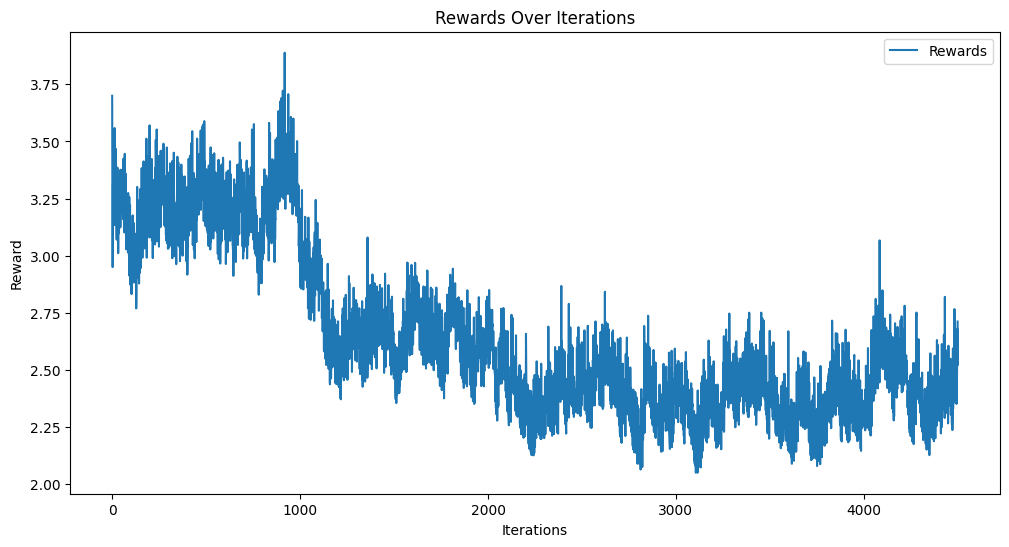

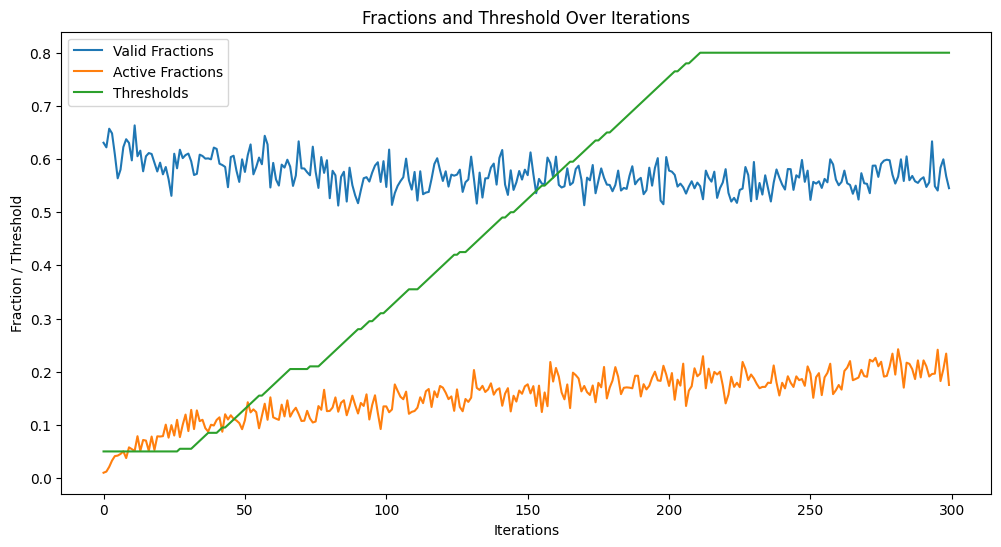

In [ ]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from rdkit import Chem, DataStructs
from sklearn.ensemble import RandomForestClassifier as RFC
from utils import canonical_smiles, get_fp
from stackRNN import StackAugmentedRNN
from data import GeneratorData
from predictor import VanillaQSAR
from reinforcement import Reinforcement
import time
import contextlib
from collections import deque
from rdkit import RDLogger

# Suppress RDKit warnings and errors
RDLogger.DisableLog('rdApp.*')

# A function to suppress stderr (error messages)
@contextlib.contextmanager
def suppress_stderr():
    with open(os.devnull, 'w') as devnull:
        old_stderr = sys.stderr
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stderr = old_stderr

def estimate_and_update(generator, predictor, n_to_generate, threshold=None, batch_size=16,
                        plot_counts=False, plot=False, return_metrics=False, **kwargs):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        with suppress_stderr():
            generated += generator.evaluate(gen_data, predict_len=120, batch_size=batch_size)

    with suppress_stderr():
        sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    unique_smiles, counts = np.unique(sanitized, return_counts=True)
    unique_smiles, counts = list(unique_smiles)[1:], counts[1:]

    smiles, prediction, nan_smiles = predictor.predict(unique_smiles, get_features=get_fp)

    if plot_counts and plot:
        plt.hist(counts)
        plt.gca().set_yscale('log')
        plt.title('Distribution of counts of generated smiles')
        plt.xlabel('Counts observed')
        plt.show()

    valid_fraction = len(prediction) / len(generated)
    active_fraction = np.mean(prediction >= threshold)
    metrics = {'valid_fraction': valid_fraction, 'active_fraction': active_fraction}

    if return_metrics:
        return smiles, prediction, metrics
    else:
        return smiles, prediction

def update_threshold(cur_threshold, prediction, proportion=0.15, step=0.005):
    if (prediction >= cur_threshold).mean() >= proportion:
        new_threshold = min(cur_threshold + step, 0.8)
        print(f"Threshold increased to: {new_threshold:.2f}")
        return new_threshold
    else:
        return cur_threshold

def simple_moving_average(prev_values, new_value, ma_window_size=10):
    ma_value = sum(prev_values[-(ma_window_size - 1):]) + new_value
    ma_value = ma_value / (len(prev_values[-(ma_window_size - 1):]) + 1.)
    return ma_value

def main(n_iterations=300, n_policy=10, n_policy_replay=15, batch_size=16, n_fine_tune=None,
         seed=None, replay_data_path='/content/rl_experiments/data/gen_actives.smi',
         primed_path='/content/rl_experiments/checkpoints/generator/checkpoint_batch_training',
         save_path=None, use_replay=True):

    # Load progress if exists, or initialize
    progress_path = '/content/drive/MyDrive/training_progress_replay.csv'
    if not os.path.exists(progress_path):
        progress_df = pd.DataFrame(columns=['iteration', 'reward', 'valid_fraction', 'active_fraction'])
    else:
        progress_df = pd.read_csv(progress_path)
        rewards = progress_df['reward'].tolist()
        valid_fractions = progress_df['valid_fraction'].tolist()
        active_fractions = progress_df['active_fraction'].tolist()

    if n_fine_tune is None:
        n_fine_tune = n_iterations

    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)

    # Load generator data and tokens
    gen_data_path = '/content/rl_experiments/data/chembl_22_clean_1576904_sorted_std_final.smi'
    tokens = [' ', '<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4',
              '7', '6', '9', '8', '=', 'a', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
              '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r']
    global gen_data
    gen_data = GeneratorData(gen_data_path, delimiter='\t',
                             cols_to_read=[0], keep_header=True, tokens=tokens)

    # Initialize Generator and Predictor
    hidden_size = 1500
    stack_width = 1500
    stack_depth = 200
    layer_type = 'GRU'
    optimizer = torch.optim.SGD
    lr = 0.0002
    generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                  output_size=gen_data.n_characters, layer_type=layer_type,
                                  n_layers=1, is_bidirectional=False, has_stack=True,
                                  stack_width=stack_width, stack_depth=stack_depth,
                                  use_cuda=torch.cuda.is_available(), optimizer_instance=optimizer, lr=lr)
    weights = torch.load(primed_path, map_location=lambda storage, loc: storage.cuda() if torch.cuda.is_available() else storage.cpu())
    generator.load_state_dict(weights)

    # Load replay data if replay is enabled
    if use_replay:
        with open(replay_data_path, 'r') as file:
            replay_data = [line.strip() for line in file.readlines()]
    else:
        replay_data = None

    # Define Predictor
    model_instance = RFC
    model_params = {'n_estimators': 250, 'n_jobs': 10}
    predictor = VanillaQSAR(model_instance=model_instance,
                            model_params=model_params,
                            model_type='classifier')
    predictor.load_model('/content/drive/MyDrive/egfr_rfc')

    # Define reward function
    def get_reward(smiles, predictor, threshold, invalid_reward=1.0, get_features=get_fp):
        mol, prop, nan_smiles = predictor.predict([smiles], get_features=get_features)
        if len(nan_smiles) == 1:
            return invalid_reward
        if prop[0] >= threshold:
            return 10.0
        else:
            return invalid_reward

    RL_model = Reinforcement(generator, predictor, get_reward)

    # Initialize metrics lists
    rl_losses = []
    rewards = []
    valid_fractions = []
    active_fractions = []
    thresholds = []
    n_to_generate = 50
    threshold = 0.05
    start = time.time()

    for i in range(n_iterations):
        print(f"{i + 1} Training on replay instances...")
        thresholds.append(threshold)

        # Use policy gradient with replay data
        if use_replay and replay_data is not None:
            for j in trange(n_policy_replay, desc=f" {i + 1} Policy gradient with replay..."):
                cur_reward, cur_loss = RL_model.policy_gradient(gen_data, replay=True, replay_data=replay_data, threshold=threshold)
                rewards.append(simple_moving_average(rewards, cur_reward))
                rl_losses.append(simple_moving_average(rl_losses, cur_loss))
        else:
            for j in trange(n_policy, desc=f" {i + 1} Policy gradient..."):
                cur_reward, cur_loss = RL_model.policy_gradient(gen_data, replay=False, threshold=threshold)
                rewards.append(simple_moving_average(rewards, cur_reward))
                rl_losses.append(simple_moving_average(rl_losses, cur_loss))

        smiles_cur, prediction_cur, metrics = estimate_and_update(RL_model.generator,
                                                                  RL_model.predictor,
                                                                  n_to_generate,
                                                                  batch_size=batch_size,
                                                                  threshold=0.75,
                                                                  plot_counts=False,
                                                                  return_metrics=True)
        valid_fractions.append(metrics['valid_fraction'])
        active_fractions.append(metrics['active_fraction'])

        new_row = pd.DataFrame([{
            'iteration': i + 1,
            'reward': rewards[-1],
            'valid_fraction': valid_fractions[-1],
            'active_fraction': active_fractions[-1]
        }])
        progress_df = pd.concat([progress_df, new_row], ignore_index=True)

        progress_df.to_csv(progress_path, index=False)

        threshold = update_threshold(threshold, prediction_cur)

    duration = time.time() - start
    print(f"Training duration: {duration} seconds")

    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label='Rewards')
    plt.title('Rewards Over Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(valid_fractions, label='Valid Fractions')
    plt.plot(active_fractions, label='Active Fractions')
    plt.plot(thresholds, label='Thresholds')
    plt.title('Fractions and Threshold Over Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Fraction / Threshold')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    main(n_iterations=300)
